In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install torchmetrics


In [3]:
pip install segmentation_models_pytorch

In [4]:
import numpy as np
from PIL import Image, ImageColor
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import segmentation_models_pytorch as smp
from torchmetrics.classification import Dice

In [5]:
parts = {1: {'col': 'orange', 'name':'hood'},
         2: {'col':'darkgreen', 'name':'front door'},
         3: {'col':'yellow', 'name':'rear door'},
         4: {'col':'cyan', 'name':'frame'},
         5: {'col':'purple', 'name':'rear quarter panel'},
         6: {'col':'lightgreen', 'name':'trunk lid'},
         7: {'col':'blue', 'name':'fender'},
         8: {'col':'pink', 'name':'bumper'},
         9: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter

def display_labels(data_arr):
    # Can take both full data and already split data
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)


In [6]:
def change_indices(labels):
  for label in labels:
    for i in range(len(label)):
      if label[i] != 0:
        label[i] = label[i] // 10
  return labels

In [7]:
class CarDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.filenames = os.listdir(self.root)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        car = arr[:,:,0:3]
        labels = change_indices( arr[:,:,3])
        # labels = arr[:,:,3]

        return car, labels

In [8]:
# Function that segments the car from background and puts it on a chosen landscape
def paste_car_into_landscape(directory_path_car, path_landscape, no_of_car_images, position, result_directory_path):
  for i in range(1, no_of_car_images+1):
      transform = transforms.Compose([transforms.ToTensor()])
      car_ind = str(i)
      wanted_size = 4

      difference = wanted_size - len(car_ind)
      padded_string = '0' * difference + car_ind
      car_path = directory_path_car + padded_string + '.png'
      # print("Car path: ", car_path)
      car_image = Image.open(car_path)
      landscape_image = Image.open(path_landscape)
      car_image = car_image.resize(landscape_image.size)
      car_size = (int(car_image.width * 0.5), int(car_image.height * 0.5))
      car_image = car_image.resize(car_size)
      input_image = transform(car_image).unsqueeze(0)

      model = maskrcnn_resnet50_fpn(pretrained=True)
      model.eval()
      with torch.no_grad():
          prediction = model(input_image)

      mask = prediction[0]['masks'][0, 0].cpu().numpy()
      car_mask_array = mask > 0.5
      car_array = np.array(car_image)
      car_array[~car_mask_array] = 0

      extracted_car = Image.fromarray(car_array)
      result_image = landscape_image.convert("RGBA")

      alpha_mask = np.uint8(car_mask_array * 255)
      alpha_channel = Image.fromarray(alpha_mask, 'L')

      result_image.paste(extracted_car, position, alpha_channel)
      result_image.save(result_directory_path + padded_string + '.png')


In [9]:
# path_landscape = "/content/drive/MyDrive/CarData/images/landscapes/0001.jpg"
# directory_path_car = "/content/drive/MyDrive/CarData/images/black_5_doors/no_segmentation/"
# position = (300, 400)
# no_of_car_images = 834
# result_directory_path = '/content/drive/MyDrive/CarData/images/black_car_landscape0001/no_segmentation/'

# paste_car_into_landscape(directory_path_car, path_landscape, no_of_car_images, position, result_directory_path)

# directory_path_car = "/content/drive/MyDrive/CarData/images/black_5_doors/with_segmentation/"
# result_directory_path = '/content/drive/MyDrive/CarData/images/black_car_landscape0001/with_segmentation/'
# paste_car_into_landscape(directory_path_car, path_landscape, no_of_car_images, position, result_directory_path)


In [10]:
codes = {(250,	149,	10): 10,
         (19,	98,	19): 20,
         (249,	249,	10): 30,
         (10,	248,	250): 40,
         (148,	8,	149): 50,
         (8,247,9): 60,
         (20,	19,	249): 70,
         (249,	9,	250): 80,
         (43,43,43): 90,
         (0, 0, 0):0}

In [11]:
# Function that changes images of cars on landscapes and images of segmented cars on landscapes to numoy arrays
def transform_into_numpy(no_of_car_images, directory_path_car, directory_path_segmen, size, result_directory):
   for i in range(1, no_of_car_images+1):
      car_ind = str(i)
      wanted_size = 4
      difference = wanted_size - len(car_ind)
      padded_string = '0' * difference + car_ind
      car_path = directory_path_car + padded_string + '.png'
      car_image = Image.open(car_path)
      car_image = car_image.resize(size)
      car_image_arr = np.array(car_image)

      # display_car(car_image_arr[:, :, :3])

      image_path = directory_path_segmen + padded_string + '.png'
      image = Image.open(image_path)
      new_size = size
      image = image.resize(new_size)
      im_arr = np.array(image)

      # display_car(im_arr[:, :, :3])

      coded_array = np.zeros_like(im_arr[:, :, 0], dtype=np.uint8)

      for color_code, code in codes.items():
          tolerance = 10
          mask = np.all(np.abs(im_arr[:, :, :3] - color_code) <= tolerance, axis=-1)
          coded_array[mask] = code

      # coded_array = change_indices(coded_array)
      # display_labels(coded_array)
      coded_image = np.dstack([car_image_arr[:, :, :3], coded_array])
      # display_labels(coded_image[:, :, 3])
      np.save(result_directory + padded_string +'.npy', coded_image)

In [12]:
# directory_path_car = "/content/drive/MyDrive/CarData/images/black_car_landscape0001/no_segmentation/"
# directory_path_segmen = "/content/drive/MyDrive/CarData/images/black_car_landscape0001/with_segmentation/"
# size = (256, 256)
# no_of_car_images = 834
# result_directory_path = '/content/drive/MyDrive/CarData/black_car_landscape0001/'

# transform_into_numpy(no_of_car_images, directory_path_car, directory_path_segmen, size, result_directory_path)

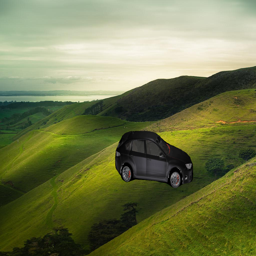

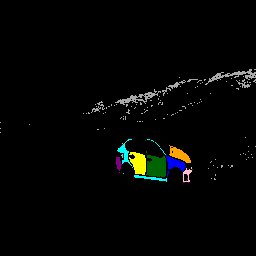

In [13]:
ds_l = CarDataset('/content/drive/My Drive/CarData/black_car_landscape0001/')
car, labels = ds_l[0]
display_car(car)
display_labels(labels)

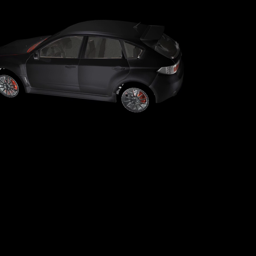

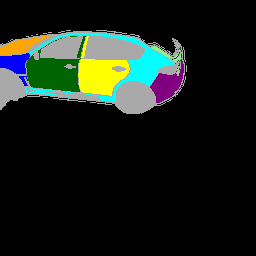

In [14]:
ds = CarDataset('/content/drive/My Drive/CarData/arrays')
car, labels = ds[1000]
display_car(car)
display_labels(labels)

In [15]:
end = len(ds)*80//100

In [16]:
sub_ind = list(range(end))

ds = ConcatDataset([ds, ds_l])

train_subset = Subset(ds, sub_ind)

train_dataloader = DataLoader(train_subset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Feature batch shape: torch.Size([16, 256, 256, 3])
Labels batch shape: torch.Size([16, 256, 256])


In [17]:
sub_ind_val = list(range(end, len(ds)))
val_subset = Subset(ds, sub_ind_val)

valid_dataloader = DataLoader(val_subset, batch_size=16, shuffle=True)

In [18]:
""" Parts of the U-Net model """


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [19]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [28]:
unet = UNet(3, 10)

In [30]:
LEARNING_RATE = 0.001
loss = CrossEntropyLoss()
# loss = smp.losses.DiceLoss('multiclass')
# loss = smp.losses.JaccardLoss('multiclass')
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, weight_decay=0.0002)


In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10

step = 0
unet.train()

train_losses = []
valid_losses = []
train_dice_scores =[]
val_dice_scores = []

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    epoch_train_losses = []
    epoch_train_dice_scores = []
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.float()
        labels = labels.long()
        inputs = inputs.permute(0, 3, 2, 1)

        # print("Inputs: ", type(inputs), " size: ", inputs.size)
        # print("Labels: ", type(labels), " size: ", labels.size)

        optimizer.zero_grad()
        unet = unet.to(device)
        output = unet(inputs)

        batch_loss = loss(output, labels)
        dice = Dice(average='micro').to(device)
        train_dice = dice(output, labels)

        epoch_train_losses.append(batch_loss.item())
        epoch_train_dice_scores.append(train_dice.item())

        batch_loss.backward()
        optimizer.step()

        step += 1

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    avg_train_dice = sum(epoch_train_dice_scores) / len(epoch_train_dice_scores)
    print("Average Training dice: ", avg_train_dice, ", Average Training loss: ", avg_train_loss)
    train_losses.append(avg_train_loss)

    with torch.no_grad():
        unet.eval()
        epoch_val_losses = []
        epoch_val_dice_scores = []
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            labels = labels.long()
            inputs = inputs.permute(0, 3, 2, 1)

            unet = unet.to(device)
            output = unet(inputs)
            val_loss = loss(output, labels)
            dice = Dice(average='micro').to(device)
            val_dice = dice(output, labels)
            epoch_val_losses.append(val_loss.item())
            epoch_val_dice_scores.append(val_dice.item())

        avg_valid_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        avg_valid_dice = sum(epoch_val_dice_scores) / len(epoch_val_dice_scores)
        print("Average Validation dice: ", avg_valid_dice, ", Average Validation loss: ", avg_valid_loss)
        valid_losses.append(avg_valid_loss)
        unet.train()



print("Finished training.")